The Rock Hyrax Problem
----------------------

Allen Downey

This notebook contains a solution to a problem I posed in my Bayesian statistics class:

> Suppose I capture and tag 10 rock hyraxes.  Some time later, I capture another 10 hyraxes and find that two of them are
> already tagged.  How many hyraxes are there in this environment?

This is an example of a mark and recapture experiment, which you can [read about on Wikipedia](http://en.wikipedia.org/wiki/Mark_and_recapture).  The Wikipedia page also includes the photo of a tagged hyrax shown above.

As always with problems like this, we have to make some modeling assumptions.

1) For simplicity, you can assume that the environment is reasonably isolated, so the number of hyraxes does not change between observations.

2) And you can assume that each hyrax is equally likely to be captured during each phase of the experiment, regardless of whether it has been tagged.  In reality, it is possible that tagged animals would avoid traps in the future, or possible that the same behavior that got them caught the first time makes them more likely to be caught again.  But let's start simple.

My solution uses the ThinkBayes2 framework, which is described in [Think Bayes](http://thinkbayes.com), and summarized in [this notebook](http://nbviewer.ipython.org/github/AllenDowney/ThinkBayes2/blob/master/code/framework.ipynb).

I'll start by defining terms:

$N$: total population of hyraxes
$K$: number of hyraxes tagged in the first round
$n$: number of hyraxes caught in the second round
$k$: number of hyraxes in the second round that had been tagged

So $N$ is the hypothesis and $(K, n, k)$ make up the data.  The probability of the data, given the hypothesis, is the probability of finding $k$ tagged hyraxes out of $n$ if (in the population) $K$ out of $N$ are tagged.  There are two ways we can compute this:

1) If you are familiar with the [hypergeometric distribution](http://en.wikipedia.org/wiki/Hypergeometric_distribution), you might recognize this problem and use an implementation of the hypergeometric PMF, evaluated at $k$.

2) Otherwise, you can figure it out using combinatorics.

I'll do the second one first.  Out of a population of $N$ hyraxes, we captured $n$; the total number of combinations is $N \choose n$.

$k$ of the ones we caught are tagged, so $n-k$ are not.  The total number of combinations is ${K \choose k}{N-K \choose n-k}$.  So the probability of the data is

${K \choose k}{N-K \choose n-k}/{N \choose n}$

`scipy.special` provides `binom(x, y)`, which computes the binomial coefficient, $x \choose y$.

So let's see how that looks in code:

In [1]:
# first a little house-keeping
from __future__ import print_function, division
% matplotlib inline

In [2]:
import thinkbayes2
from scipy.special import binom

class Hyrax(thinkbayes2.Suite):
    """Represents hypotheses about how many hyraxes there are."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: total population (N)
        data: # tagged (K), # caught (n), # of caught who were tagged (k)
        """
        N = hypo
        K, n, k = data

        if hypo < K + (n - k):
            return 0

        like = binom(N-K, n-k) / binom(N, n)
        return like

Again $N$ is the hypothesis and $(K, n, k)$ is the data.  If we've tagged $K$ hyraxes and then caught another $n-k$, the total number of unique hyraxes we're seen is $K + (n - k)$.  For any smaller value of N, the likelihood is 0.

Notice that I didn't bother to compute $K \choose k$; because it does not depend on $N$, it's the same for all hypotheses, so it gets cancelled out when we normalize the suite.

Next I construct the prior and update it with the data.  I use a uniform prior from 0 to 999.

In [3]:
hypos = range(1, 1000)
suite = Hyrax(hypos)

data = 10, 10, 2
suite.Update(data)

0.0010248876709531896

Here's what the posterior distribution looks like:

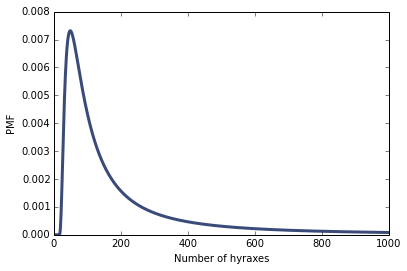

In [4]:
import thinkplot
thinkplot.Pdf(suite)
thinkplot.Config(xlabel='Number of hyraxes', ylabel='PMF', legend=False)

And here are some summaries of the posterior distribution:

In [5]:
print('Posterior mean', suite.Mean())
print('Maximum a posteriori estimate', suite.MaximumLikelihood())
print('90% credible interval', suite.CredibleInterval(90))

Posterior mean 185.570957948
Maximum a posteriori estimate 50
90% credible interval (36, 618)


The combinatorial expression we computed is the PMF of the hypergeometric distribution, so we can also compute it using `thinkbayes2.EvalHypergeomPmf`, which uses `scipy.stats.hypergeom.pmf`.

In [6]:
import thinkbayes2

class Hyrax2(thinkbayes2.Suite):
    """Represents hypotheses about how many hyraxes there are."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: total population (N)
        data: # tagged (K), # caught (n), # of caught who were tagged (k)
        """
        N = hypo
        K, n, k = data

        if hypo < K + (n - k):
            return 0

        like = thinkbayes2.EvalHypergeomPmf(k, N, K, n)
        return like


And the result is the same:

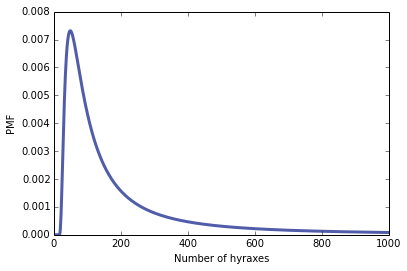

In [7]:
hypos = range(1, 1000)
suite = Hyrax2(hypos)

data = 10, 10, 2
suite.Update(data)

thinkplot.Pdf(suite)
thinkplot.Config(xlabel='Number of hyraxes', ylabel='PMF', legend=False)

In [8]:
print('Posterior mean', suite.Mean())
print('Maximum a posteriori estimate', suite.MaximumLikelihood())
print('90% credible interval', suite.CredibleInterval(90))

Posterior mean 185.570957948
Maximum a posteriori estimate 50
90% credible interval (36, 618)


If we run the analysis again with a different prior (running from 0 to 1999), the MAP is the same, but the posterior mean and credible interval are substantially different:

In [9]:
hypos = range(1, 2000)
suite = Hyrax2(hypos)
data = 10, 10, 2
suite.Update(data)

print('Posterior mean', suite.Mean())
print('Maximum a posteriori estimate', suite.MaximumLikelihood())
print('90% credible interval', suite.CredibleInterval(90))

Posterior mean 233.983126212
Maximum a posteriori estimate 50
90% credible interval (36, 890)


This difference indicates that we don't have enough data to swamp the priors, so a more definitive answer would require either more data or a prior based on more background information.